In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from detecta import detect_peaks, detect_onset
from glob import glob
from tqdm import tqdm
import scipy.signal as signal
import warnings
warnings.filterwarnings('ignore')

def lowpass_filter(data, sr, cut_off, order):
    nyq = 0.5 * sr
    b, a = signal.butter(order, cut_off/nyq, btype = 'low')
    lp_df = signal.filtfilt(b, a, data)
    return lp_df

def ang_vel_made(data, sr):
    x = np.diff(data) / (1 / sr)
    x = pd.Series(x, index = np.arange(1,len(data)))
    return x      

In [20]:
day = '20240103'

In [21]:
file_list = [i.replace('\\','/') for i in sorted(glob(f"visual 3d file/{day}/*txt"))]
file_name = []
for i in file_list:
    file, _, _ = os.path.basename(i).split('.')
    file_name.append(file)
    
file_name

['ryuhanjun_0001_R_87_182_OH_135_S',
 'ryuhanjun_0002_R_87_182_OH_134_S',
 'ryuhanjun_0003_R_87_182_OH_137_S',
 'ryuhanjun_0004_R_87_182_OH_135_S',
 'ryuhanjun_0005_R_87_182_OH_134_S',
 'ryuhanjun_0006_R_87_182_OH_135_S',
 'ryuhanjun_0007_R_87_182_OH_134_S',
 'ryuhanjun_0008_R_87_182_OH_135_S',
 'ryuhanjun_0010_R_87_182_OH_135_S']

In [22]:
BR = pd.read_excel(f'c3d file/{day}/player_information.xlsx',index_col = 'trial')

In [14]:
dataset = {
    'force' : {},
    'kine'  : {}
    }

wrong = {     # 시점 컨택 안된 데이터 모으기
    'force' : {},
    'kine'  : {}
    } 
non_force = {}

for file, name in zip(file_list, file_name):
    df = pd.read_csv(file, sep='\t', encoding='cp949', header=[1,2,3,4])
    df.drop('Unnamed: 0_level_0', axis=1, inplace=True)
    df.drop('LAR_ROTMAT', axis=1, inplace=True)
    kinematic_len = len(df['FRAMES'].dropna())
    kinetic_len = kinematic_len * 6

    cols = []
    for col in df.columns:
        if col[0] not in ['FP1','FP2']:
            cols.append(col)

    kine = df[cols].iloc[:kinematic_len, :]
    force = df[['FP1','FP2']].iloc[:kinetic_len,:]

    kg = float(name.split('_')[3])
    height = float(name.split('_')[4])
    
    for_cols = []
    for col in force.columns:
        side, data, _, axis = col
        if side == 'FP1':
            side = 'REAR'
        else:
            side = 'LEAD'
        
        for_cols.append(f"{side}_{data}_{axis}")
        
    force.columns = for_cols

    # non_force[name] = force
    for col in for_cols:
        if ('FORCE' in col) | ('FREEMOMENT' in col):
            force[col] = lowpass_filter(force[col], 1080, 40, 4)
            force[col] = 100 * (force[col] / 9.81) / kg
            
            
    kine_cols = []
    for col in kine.columns:
        data, _, ro, axis = col
        if data in ['FRAMES','TIME']:
            kine_cols.append(data)
        elif data in ['ProxEndPos']:
            kine_cols.append(f"{ro}_{axis}")
        else:
            kine_cols.append(f"{data}_{axis}")
            
    for idx ,col in enumerate(kine_cols):
        if 'R' in file: # 오른손 투수
            pit_type = 'R'
            if ('ANKLE' in col) | ('HIP' in col) | ('KNEE' in col) | ('HEEL' in col):
                split_col = col.split('_')
                
                if 'R' in split_col[0]: # 오른손 투수의 오른쪽 다리 => REAR
                    split_col[0] = 'REAR'
                    split_col = '_'.join(split_col)
                    kine_cols[idx] = split_col
                elif 'L' in split_col[0]: # 오른손 투수의 왼쪽 다리 => LEAD
                    split_col[0] = 'LEAD'
                    split_col = '_'.join(split_col)
                    kine_cols[idx] = split_col

            elif ('ELBOW' in col) | ('SHOULDER' in col) | ('WRIST' in col):
                split_col = col.split('_')
                
                if 'R' in col.split('_')[0]: # 오른손 투수의 오른쪽 팔 => LEAD
                    split_col[0] = 'LEAD'
                    split_col = '_'.join(split_col)
                    kine_cols[idx] = split_col
                elif 'L' in col.split('_')[0]: # 오른손 투수의 왼쪽 팔 => REAR
                    split_col[0] = 'REAR'
                    split_col = '_'.join(split_col)
                    kine_cols[idx] = split_col
                    
        elif 'L' in file: # 왼손 투수
            pit_type = 'L'
            if ('ANKLE' in col) | ('HIP' in col) | ('KNEE' in col) | ('HEEL' in col):
                split_col = col.split('_')
                
                if 'R' in split_col[0]: # 왼쪽 투수의 오른쪽 다리 => LEAD
                    split_col[0] = 'LEAD'
                    split_col = '_'.join(split_col)
                    kine_cols[idx] = split_col
                elif 'L' in split_col[0]: # 왼쪽 투수의 왼쪽 다리 => REAR
                    split_col[0] = 'REAR'
                    split_col = '_'.join(split_col)
                    kine_cols[idx] = split_col
                    
            elif ('ELBOW' in col) | ('SHOULDER' in col) | ('WRIST' in col):
                split_col = col.split('_')
                
                if 'R' in col.split('_')[0]: # 왼쪽 투수의 오른쪽 팔 => REAR
                    split_col[0] = 'REAR'
                    split_col = '_'.join(split_col)
                    kine_cols[idx] = split_col
                elif 'L' in col.split('_')[0]: # 왼쪽 투수의 왼쪽 팔 => LEAD
                    split_col[0] = 'LEAD'
                    split_col = '_'.join(split_col)
                    kine_cols[idx] = split_col
                        
    for idx, col in enumerate(kine_cols):
        if ('LTH' in col) | ('RTH' in col) | ('LAR' in col) | ('RAR' in col):
            split_col = col.split('_')
            if split_col[2] in ['LTH','RTH']:
                split_col[2] = 'TH'
                
            elif split_col[2] in ['LAR','RAR']:
                split_col[2] = 'AR'
            
            split_col = '_'.join(split_col)
            
            kine_cols[idx] = split_col
    
    newcols = []
    for col in kine_cols:
        if pit_type == 'R':
            if col in ['RFA_X', 'RFA_Y', 'RFA_Z', 'LFA_X', 'LFA_Y', 'LFA_Z', 'RHA_X', 'RHA_Y', 'RHA_Z', 'LHA_X', 'LHA_Y', 'LHA_Z']:
                if 'R' in col:
                    col = 'LEAD_' + col[1:]
                elif 'L' in col:
                    col = 'REAR_' + col[1:]

                newcols.append(col)    
                
            else:
                newcols.append(col)
        elif pit_type == 'L':
            if col in ['RFA_X', 'RFA_Y', 'RFA_Z', 'LFA_X', 'LFA_Y', 'LFA_Z', 'RHA_X', 'RHA_Y', 'RHA_Z', 'LHA_X', 'LHA_Y', 'LHA_Z']:
                if 'R' in col:
                    col = 'REAR_' + col[1:]
                elif 'L' in col:
                    col = 'LEAD_' + col[1:]

                newcols.append(col)        
            else:
                newcols.append(col)

    kine.columns = newcols

    ang_cols = []
    vel_cols = []
    for col in kine_cols:
        if 'ANGLE' in col:
            ang_cols.append(col)
        if 'ANGULAR' in col:
            vel_cols.append(col)
            
    for col in ang_cols:
        up = np.where((np.diff(kine[col]) > 300))[0].tolist()
        down = np.where((np.diff(kine[col]) < -300))[0].tolist()
        all = sorted([*up, *down])
        all_len = len(all)
        
        if (len(up) == 0) & (len(down) == 0):
            pass
        
        elif (len(up) == 1) & (len(down) == 0):
            kine[col].iloc[all[0]+1:] = kine[col].iloc[all[0]+1:] - 360

        elif (len(up) == 0) & (len(down) == 1):
            kine[col].iloc[all[0]+1:] = kine[col].iloc[all[0]+1:] + 360

        elif (len(up) >= 1) & (len(down) >= 1):
            if up[0] < down[0]:
                if all_len % 2 == 0:
                    for i in range(0,all_len,2):
                        kine[col].iloc[all[i]+1:all[i+1]+1] = kine[col].iloc[all[i]+1:all[i+1]+1] - 360
                elif all_len % 2 == 1:
                    for i in range(0,all_len - 1, 2):
                        kine[col].iloc[all[i]+1:all[i+1]+1] = kine[col].iloc[all[i]+1:all[i+1]+1] - 360
                    kine[col].iloc[all[-1]+1:] = kine[col].iloc[all[-1]+1:] - 360                                               
            elif up[0] > down[0]:
                if all_len % 2 == 0:
                    for i in range(0,all_len,2):
                        kine[col].iloc[all[i]+1:all[i+1]+1] = kine[col].iloc[all[i]+1:all[i+1]+1] + 360
                elif all_len % 2 == 1:
                    for i in range(0,all_len - 1, 2):
                        kine[col].iloc[all[i]+1:all[i+1]+1] = kine[col].iloc[all[i]+1:all[i+1]+1] + 360
                    kine[col].iloc[all[-1]+1:] = kine[col].iloc[all[-1]+1:] + 360
    
    kine['PELVIS_ANGLUAR_VELOCITY_X'] = ang_vel_made(kine['PELVIS_ANGLE_X'], 180)
    kine['PELVIS_ANGLUAR_VELOCITY_Y'] = ang_vel_made(kine['PELVIS_ANGLE_Y'], 180)
    kine['PELVIS_ANGLUAR_VELOCITY_Z'] = ang_vel_made(kine['PELVIS_ANGLE_Z'], 180)
    kine['TORSO_ANGLUAR_VELOCITY_X'] = ang_vel_made(kine['TORSO_ANGLE_X'], 180)
    kine['TORSO_ANGLUAR_VELOCITY_Y'] = ang_vel_made(kine['TORSO_ANGLE_Y'], 180)
    kine['TORSO_ANGLUAR_VELOCITY_Z'] = ang_vel_made(kine['TORSO_ANGLE_Z'], 180)
    
    kine = kine.fillna(0)
    
    for col in kine.columns:
        if col not in ['FRAMES','TIME']:
            kine[col] = lowpass_filter(kine[col],180,13.4,4)
       
    for col in ang_cols:    
        if pit_type == 'L':
            split_col = col.split('_')
            if split_col[-1] in ['Y', 'Z']:
                kine[col] = - kine[col]
    
    for col in vel_cols:    
        if pit_type == 'L':
            split_col = col.split('_')
            if split_col[-1] in ['Y', 'Z']:
                kine[col] = - kine[col]

    change_minus_plus = ['LEAD_SHOULDER_ANGLE_Z','LEAD_KNEE_ANGLE_X',
                         'TORSO_ANGLE_X','TORSO_ANGLE_Y','LEAD_ELBOW_ANGULAR_VELOCITY_X', 'LEAD_SHOULDER_ANGLE_Y']
    if pit_type == 'L':
        change_minus_plus.extend(['PELVIS_ANGLUAR_VELOCITY_Z','TORSO_ANGLUAR_VELOCITY_Z','LEAD_SHOULDER_ANGLE_X'])
        
    kine[change_minus_plus] = - kine[change_minus_plus]
    
    stide_length = round(100 * (kine['LEAD_HEEL_Y'] - kine['REAR_HEEL_Y']).max() * 100 / height,2)
    
    session = f"{name.split('_')[0]}_{name.split('_')[1]}"

    resultant_force = force['LEAD_FORCE_X']+force['LEAD_FORCE_Y']+force['LEAD_FORCE_Z']

    sr = 180
    plot = False
    try:
        # print(f"===================={name}=======================")
        kh_time = detect_peaks(kine['LEAD_HEEL_Z'], mpd = sr * 5, mph = 0.4, show=plot)[0]
        fc_time = int(detect_onset(resultant_force, threshold=10, n_above=sr * 0.3, n_below = sr * 0.3, show=plot)[0][0] / 6)
        fp_time = int(detect_onset(resultant_force, threshold=100, n_above=sr * 0.3, n_below = sr * 2, show=plot)[0][0] / 6)
        mer_time = detect_peaks(kine['LEAD_SHOULDER_ANGLE_Z'], mpd = sr * 5, mph = 130, show=plot)[0]
        mir_time = detect_peaks(kine['LEAD_SHOULDER_ANGULAR_VELOCITY_Z'], mpd = sr * 5, mph = 1500, show=plot)[0]

        # br_time
        FHA = kine['LEAD_FA_Y'] - kine['LEAD_HA_Y']
        FHA_index = FHA[FHA >= 0].index
        
        br_time = detect_onset (FHA, threshold=0, show=plot)
        br_time = np.concatenate(br_time).tolist()

        for onset in br_time:
            if onset > mer_time:
                br_time = onset
                break
        
        br_time = br_time+2
        
        # print(name,':',kh_time,fc_time,fp_time,mer_time,br_time,mir_time)
        
        if kh_time > fc_time:
            print(f'{name} : kh_time 가 fc_time 보다 큼')
        if fc_time > fp_time:
            print(f'{name} : fc_time 가 fp_time 보다 큼')
        if fp_time > mer_time:
            print(f'{name} : fp_time 가 mer_time 보다 큼')
        if mer_time > br_time:
            print(f'{name} : mer_time 가 br_time 보다 큼')
            
        kine['kh_time'] = kh_time
        kine['fc_time'] = fc_time
        kine['fp_time'] = fp_time
        kine['mer_time'] = mer_time
        kine['br_time'] = br_time
        kine['mir_time'] = mir_time
        kine['stride_length'] = stide_length
        
        force['kh_time'] = kh_time * 6
        force['fc_time'] = fc_time * 6
        force['fp_time'] = fp_time * 6
        force['mer_time'] = mer_time * 6
        force['br_time'] = br_time * 6
        force['mir_time'] = mir_time * 6

        lead_peak = detect_peaks(force['LEAD_FORCE_Z'].iloc[force['fc_time'][0]:force['br_time'][0]], mph=100, mpd=50, show=plot) + force['fc_time'][0]
        force['lead_peak_z'] = lead_peak[0]
        
        # for col in for_cols:
        #     if ('FORCE' in col) | ('FREEMOMENT' in col):
        #         force[col] = lowpass_filter()
        
        dataset['force'][name] = force
        dataset['kine'][name] = kine
        
    except Exception:
        print(f"{name} 에서 시점 찾기 오류 발생")
        wrong['kine'][name] = kine
        wrong['force'][name] = force
    # print(name)

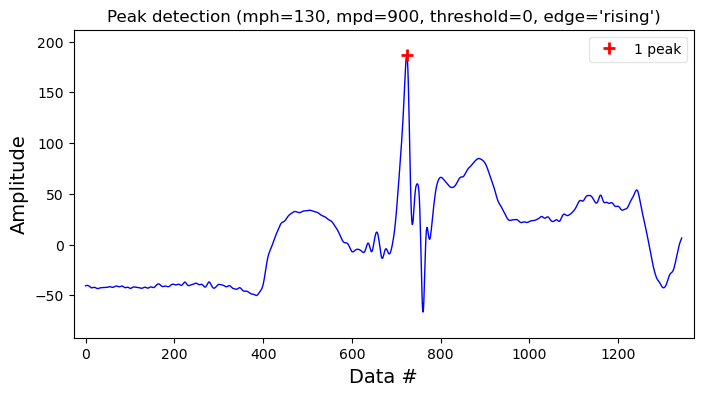

724

In [15]:
detect_peaks(kine['LEAD_SHOULDER_ANGLE_Z'], mpd = sr * 5, mph = 130, show=True)[0]

In [16]:
for name in dataset['kine']:
    kine = dataset['kine'][name]
    force = dataset['force'][name]
    kine.to_csv(f"processed file/{day}/kine/{name}.csv", index=False)
    force.to_csv(f"processed file/{day}/force/{name}.csv", index=False)

### 문제 확인


In [17]:
w = [i for i in wrong['kine']]
w

[]

In [18]:
name = ['kimjiwoo_0005_R_85_183_OH_118_S']
kine = wrong['kine'][name[0]]
force = wrong['force'][name[0]]
session = [i.split('_')[0] + '_' + i.split('_')[1] for i in name]

KeyError: 'kimjiwoo_0005_R_85_183_OH_118_S'

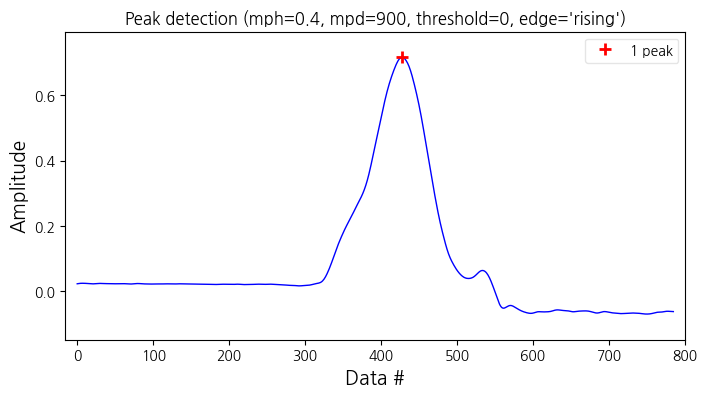

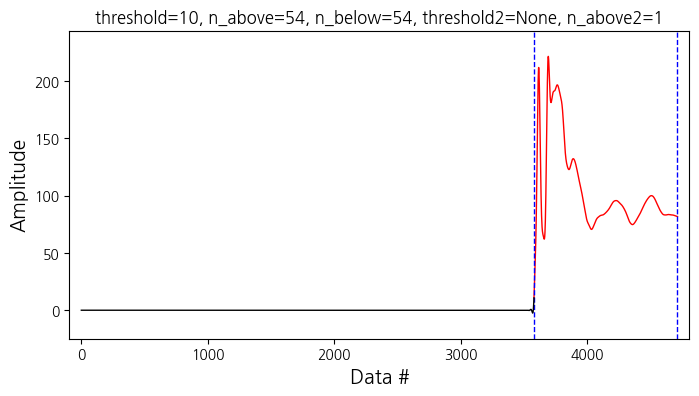

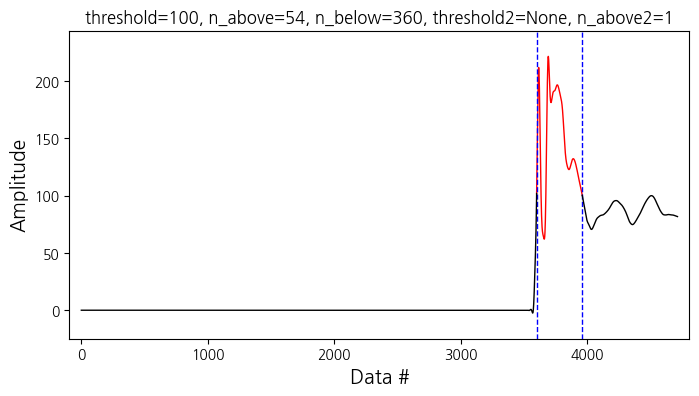

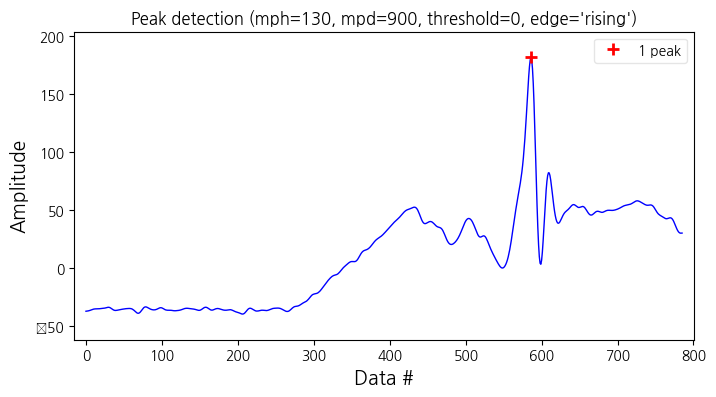

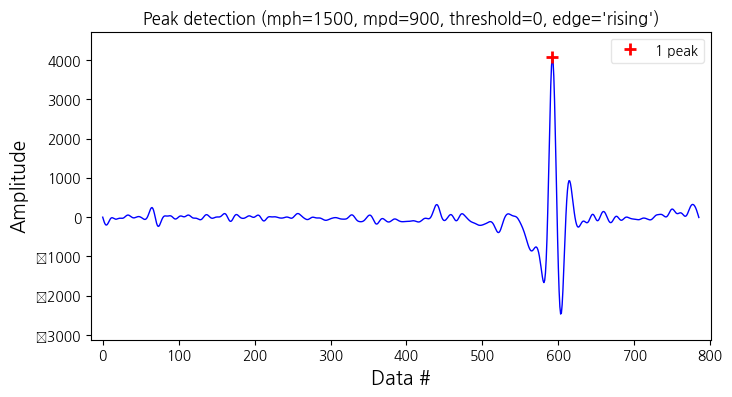

['kimjiwoo_0005_R_85_183_OH_118_S'] : 428 596 600 586 593 592


In [ ]:
plot = True

kh_time = detect_peaks(kine['LEAD_HEEL_Z'], mpd = sr * 5, mph = 0.4, show=plot)[0]
fc_time = int(detect_onset(force['LEAD_FORCE_Z'], threshold=10, n_above=sr * 0.3, n_below = sr * 0.3, show=plot)[0][0] / 6)
fp_time = int(detect_onset(force['LEAD_FORCE_Z'], threshold=100, n_above=sr * 0.3, n_below = sr * 2, show=plot)[0][0] / 6)
mer_time = detect_peaks(kine['LEAD_SHOULDER_ANGLE_Z'], mpd = sr * 5, mph = 130, show=plot)[0]
mir_time = detect_peaks(kine['LEAD_SHOULDER_ANGULAR_VELOCITY_Z'], mpd = sr * 5, mph = 1500, show=plot)[0]
br_time = int(BR.loc[session]['br_frame'])
print(name,':',kh_time,fc_time,fp_time,mer_time,br_time,mir_time)

kine['kh_time'] = kh_time
kine['fc_time'] = fc_time
kine['fp_time'] = fp_time
kine['mer_time'] = mer_time
kine['br_time'] = br_time
kine['mir_time'] = mir_time

force['kh_time'] = kh_time * 6
force['fc_time'] = fc_time * 6
force['fp_time'] = fp_time * 6
force['mer_time'] = mer_time * 6
force['br_time'] = br_time * 6
force['mir_time'] = mir_time * 6

In [ ]:
BR.loc[session]['br_frame']

trial
kimjiwoo_0005    593
Name: br_frame, dtype: int64